# Training file for RDN

## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()


if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

from rdn import RDN

print(device)

cuda


# Utility function

In [2]:
class SuperResolutionStatsManager(nt.StatsManager):
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0
        self.running_ssim = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        d_numpy = d.detach().to('cpu').numpy()
        y_numpy = y.detach().to('cpu').numpy()

        self.running_psnr += metrics.peak_signal_noise_ratio(d_numpy, y_numpy)

        current_ssim = 0

        for i in range(d_numpy.shape[0]):
            d_numpy_temp = np.moveaxis(d_numpy[i], [0, 1, 2], [2, 0, 1])
            y_numpy_temp = np.moveaxis(y_numpy[i], [0, 1, 2], [2, 0, 1])

            value_range = max(d_numpy_temp.max(), y_numpy_temp.max()) - min(d_numpy_temp.min(), y_numpy_temp.min())
            
            current_ssim += metrics.structural_similarity(d_numpy_temp, y_numpy_temp, win_size=7, data_range=value_range, multichannel=True, channel_axis=2)
        
        self.running_ssim += current_ssim / d_numpy.shape[0]

    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        ssim = self.running_ssim / (self.number_update+1e-9 )
        return {'loss': loss, 'psnr': psnr, "ssim": ssim}

def criterion(y, d):
    return F.mse_loss(y, d)

#show image
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    # ax.axis('off')
    return h

## Data loader

In [3]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import your datasetclass
from lowhighresimagedataset import LowAndHighResImageDataset

X_train = LowAndHighResImageDataset(transform=train_transform, train=True, onDevice=device)
X_valid = LowAndHighResImageDataset(transform=valid_transform, train=False, onDevice=device)
X_train.get_info()

#train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
#valid_loader = DataLoader(X_valid, batch_size=32, shuffle=True)

Number of train low resolution images: 800
Number of train high resolution images: 800
Number of valid low resolution images: 200
Number of valid high resolution images: 200


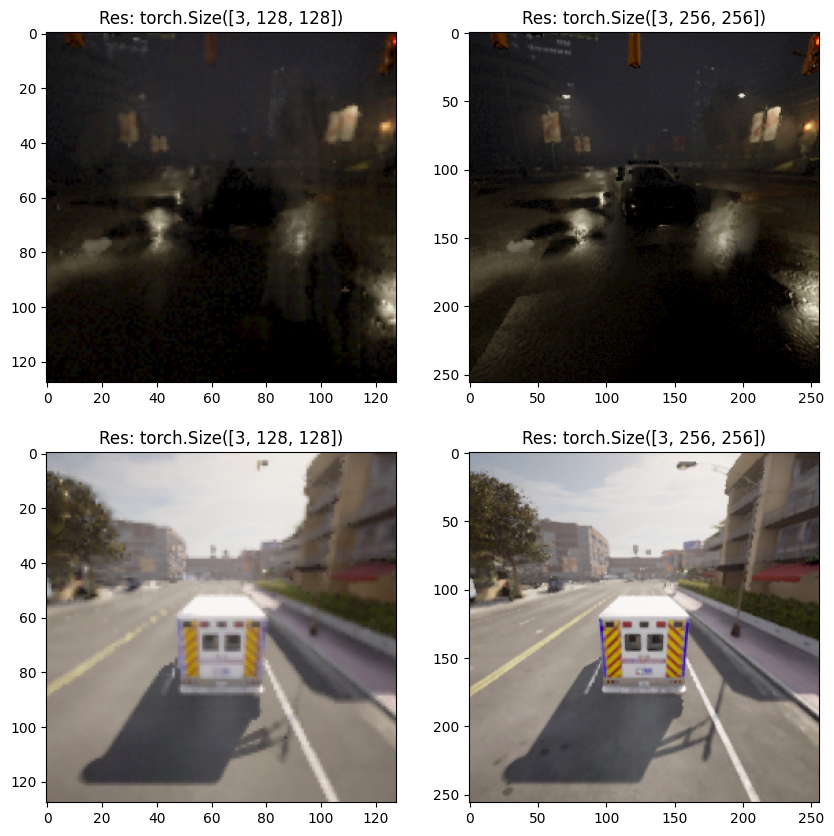

In [5]:
#printing some 2 pairs of low res/high res images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ex_low_res1, ex_high_res1 = X_train[np.random.randint(len(X_train))]
ex_low_res2, ex_high_res2 = X_train[np.random.randint(len(X_train))]
ex = [ex_low_res1, ex_high_res1, ex_low_res2, ex_high_res2]
for i, ax in enumerate(axes.flat):
    ax.set_title(f'Res: {ex[i].shape}')
    myimshow(ex[i], ax=ax)

In [6]:
# Plot for the the predicted image, low resolution image and high resolution image in first row
# plot Plot the loss, psnr and ssim curves in the second row
def plot_images_and_metrics(exp, fig, axes, dataset, index): ##Only to use when perform_validation_during_training == True
    low_res, high_res = dataset[index]

    with torch.no_grad():
        predicted_res = exp.net(low_res)[0]

    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()

    axes[0][0].set_title(f'Low res: {low_res.detach().cpu().numpy().shape}')
    axes[0][1].set_title(f'High res: {high_res.detach().cpu().numpy().shape}')
    axes[0][2].set_title(f'Predicted res: {predicted_res.detach().cpu().numpy().shape}')

    axes[0][0].imshow(low_res.detach().cpu().numpy().transpose(1, 2, 0))
    axes[0][1].imshow(high_res.detach().cpu().numpy().transpose(1, 2, 0))
    axes[0][2].imshow(predicted_res.detach().cpu().numpy().transpose(1, 2, 0))

    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="Train loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="Train psnr")
    axes[1][2].plot([exp.history[k][0]['ssim'] for k in range(exp.epoch)], label="Train ssim")

    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="Eval loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="Eval psnr")
    axes[1][2].plot([exp.history[k][1]['ssim'] for k in range(exp.epoch)], label="Eval ssim")

    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR") 
    axes[1][2].legend()
    axes[1][2].set_xlabel("Epoch")
    axes[1][2].set_ylabel("SSIM")

## Experiment on a small batch

In [7]:
dataset_size = 20
small_dataset = [X_train[np.random.randint(len(X_train))] for _ in range(dataset_size)]


small_train_size = int(0.8 * len(small_dataset))
small_valid_size = len(small_dataset) - small_train_size
small_train_dataset, small_valid_dataset = torch.utils.data.random_split(small_dataset, [small_train_size, small_valid_size])


lr = 1e-3
r = RDN(C=3 , D=10, G=32, G0=32, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
exp = nt.Experiment(r, small_dataset, small_valid_dataset, adam, stats_manager, device, criterion, batch_size=1,
                     output_dir="../results/smallbatchexperiement4", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 (Time: 0.72s) Loss: 0.04388 psnr: 18.641535246044015 ssim: 0.418465673818876
Epoch 2 (Time: 0.59s) Loss: 0.01279 psnr: 20.932460807865244 ssim: 0.5316006986957971
Epoch 3 (Time: 0.59s) Loss: 0.00919 psnr: 19.436580337195554 ssim: 0.5373385621754073
Epoch 4 (Time: 0.59s) Loss: 0.00968 psnr: 20.884934768631926 ssim: 0.5521284265926006
Epoch 5 (Time: 0.59s) Loss: 0.00750 psnr: 21.014074446205782 ssim: 0.5817542745208708
Epoch 6 (Time: 0.60s) Loss: 0.00757 psnr: 21.557141403555836 ssim: 0.5863889901364151
Epoch 7 (Time: 0.59s) Loss: 0.00622 psnr: 21.70659757098837 ssim: 0.6114571987053968
Epoch 8 (Time: 0.60s) Loss: 0.00560 psnr: 22.355262008964427 ssim: 0.6472028939298055
Epoch 9 (Time: 0.59s) Loss: 0.00483 psnr: 23.169543341803063 ssim: 0.6855112461522077
Epoch 10 (Time: 0.59s) Loss: 0.00451 psnr: 23.27682640440354 ssim: 0.6929672805722644
Epoch 11 (Time: 0.58s) Loss: 0.00440 psnr: 22.82897028775168 ssim: 0.7045004962113566
Epoch 12 (Time: 0.5

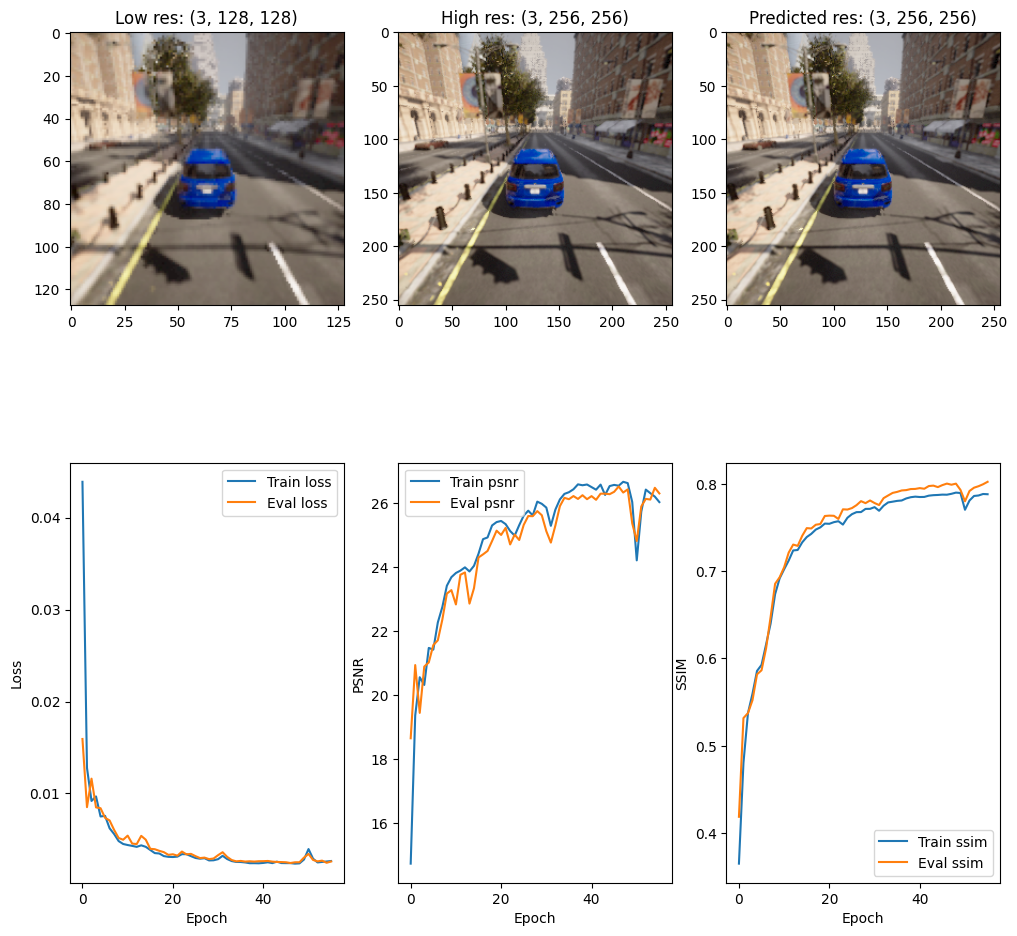

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
exp.run(num_epochs=56, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, small_valid_dataset, np.random.randint(len(small_valid_dataset))))

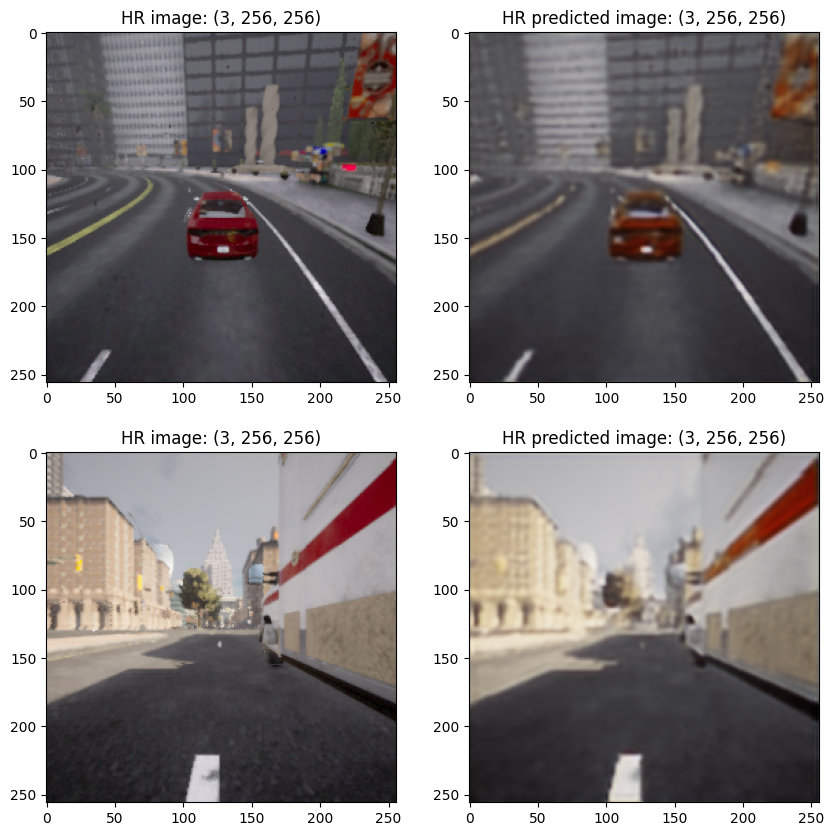

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
train_low_res1, train_high_res1 = small_dataset[np.random.randint(len(small_dataset))]
train_low_res2, train_high_res2 = small_dataset[np.random.randint(len(small_dataset))]
pred_high_res1 = exp.net(train_low_res1)[0]
pred_high_res2 = exp.net(train_low_res2)[0]
ex = [train_high_res1, pred_high_res1, train_high_res2, pred_high_res2]
for i, ax in enumerate(axes.flat):
    if i%2 == 0:
        ax.set_title(f'HR image: {ex[i].detach().cpu().numpy().shape}')
    else:
         ax.set_title(f'HR predicted image: {ex[i].detach().cpu().numpy().shape}')
    myimshow(ex[i], ax=ax)

# Training the data

In [10]:
train_size = int(0.8 * len(X_train))
valid_size = len(X_train) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(X_train, [train_size, valid_size])

In [11]:
lr = 1e-3
batch_size = 32
r = RDN(C=3 , D=10, G=16, G0=16, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
exp1 = nt.Experiment(r, train_dataset, valid_dataset, adam, stats_manager, device, criterion, batch_size=batch_size,
                     output_dir="../results/superresol1000", perform_validation_during_training=True)

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
exp1.run(num_epochs=10, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, X_valid, np.random.randint(len(X_valid))))
#exp1.run(num_epochs=3, plot=None)

Start/Continue training from epoch 0


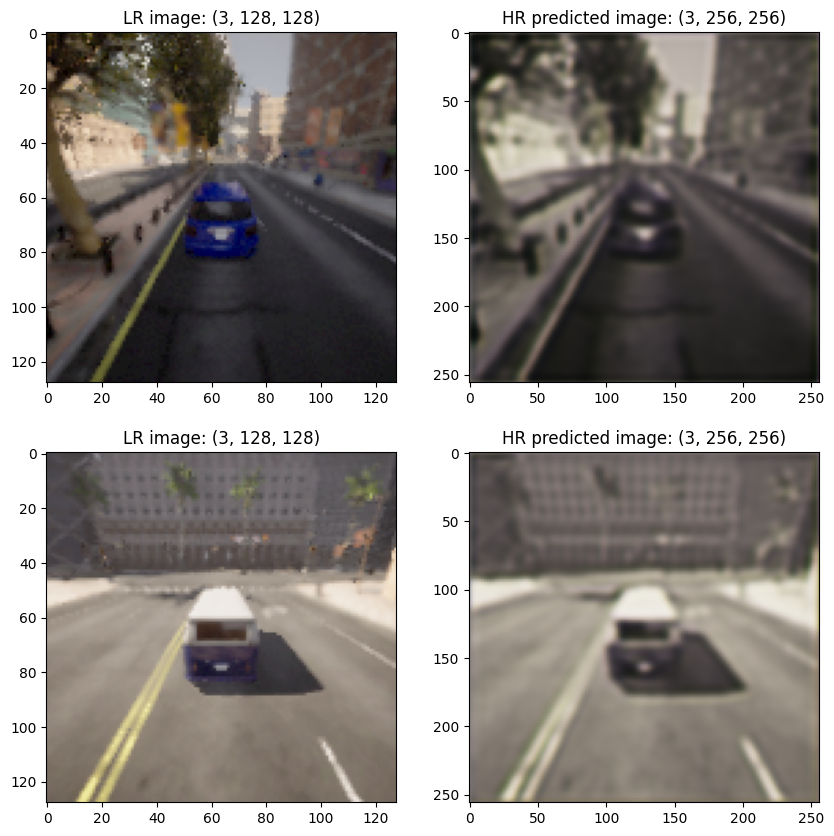

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
test_low_res1, _ = X_valid[np.random.randint(len(X_valid))]
test_low_res2, _ = X_valid[np.random.randint(len(X_valid))]
pred_high_res1 = exp1.net(test_low_res1)[0]
pred_high_res2 = exp1.net(test_low_res2)[0]
ex = [test_low_res1, pred_high_res1, test_low_res2, pred_high_res2]
for i, ax in enumerate(axes.flat):
    if i%2 == 0:
        ax.set_title(f'LR image: {ex[i].detach().cpu().numpy().shape}')
    else:
         ax.set_title(f'HR predicted image: {ex[i].detach().cpu().numpy().shape}')
    myimshow(ex[i], ax=ax)

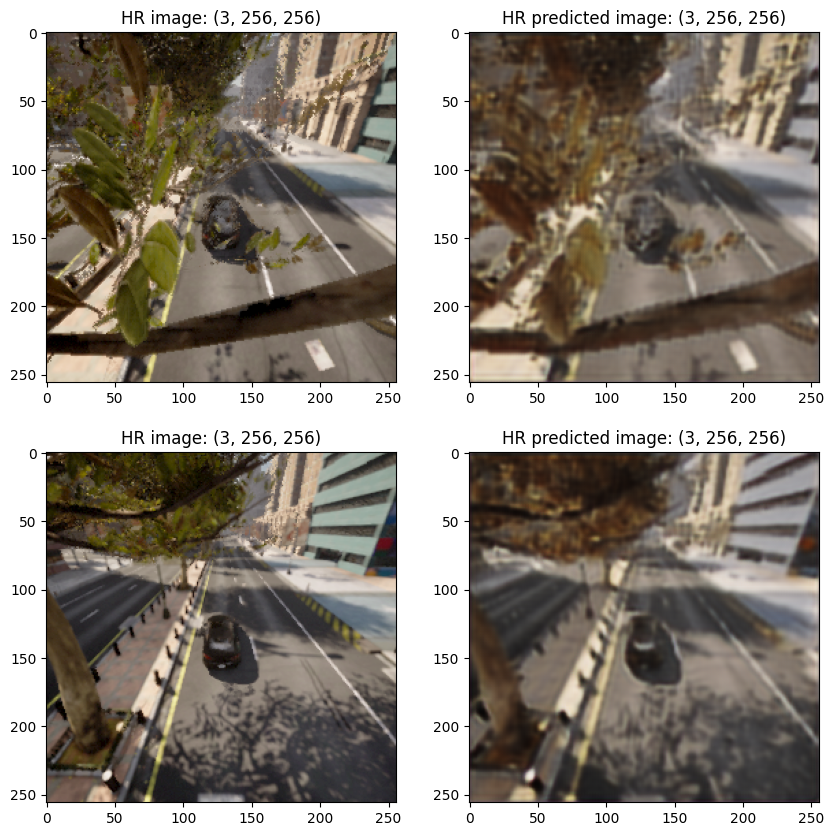

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
test_low_res1, test_high_res1 = X_valid[np.random.randint(len(X_valid))]
test_low_res2, test_high_res2 = X_valid[np.random.randint(len(X_valid))]
pred_high_res1 = exp.net(test_low_res1)[0]
pred_high_res2 = exp.net(test_low_res2)[0]
ex = [test_high_res1, pred_high_res1, test_high_res2, pred_high_res2]
for i, ax in enumerate(axes.flat):
    if i%2 == 0:
        ax.set_title(f'HR image: {ex[i].detach().cpu().numpy().shape}')
    else:
         ax.set_title(f'HR predicted image: {ex[i].detach().cpu().numpy().shape}')
    myimshow(ex[i], ax=ax)